In [1]:
import numpy as np

from scorta.recsys.candidate_generate import CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
import polars as pl

from hydra import initialize, compose
from scorta.utils.utils import seed_everything

from scorta.feature.feature import FeatureMerger
from atma_16.feature.feature import YadoRawFeature, YadoRankFeature, SessionFeature

In [2]:
seed_everything()

exp_name = "004_add_discussion_candidates"
input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

feature_dir = input_dir / "feature"
feature_dir.mkdir(exist_ok=True)

output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)


with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")
    print(cfg.feature)

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()

yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

{'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], 'key_cols': ['yad_no']}, 'Session': {'feature_cols': ['user_mode_wid_cd', 'user_mode_ken_cd', 'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg', 'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min', 'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5min'], 'key_cols': ['session_id']}, 'YadoRank': {'feature_cols': ['yad_cnt', 'yad_cnt_rank', 'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd', 'yad_cnt_rank_sml_cd'], 'key_cols': ['yad_no']}}


In [3]:
train_log = dl.load_train_log()
label = dl.load_train_label()
test_log = dl.load_train_log()

In [4]:
from atma_16.candidate.candidate import (
    LastSeenedCandidate,
    PopularAtCDCandidate,
    TopBookedFromLastViewCandidate,
    CoVisitCandidate,
)

train_candidates = [
    CoVisitCandidate(dl, candidate_dir, target_df=target_df),
    TopBookedFromLastViewCandidate(dl, candidate_dir, target_df=target_df),
    LastSeenedCandidate(dl, candidate_dir, target_df=target_df),
    PopularAtCDCandidate(dl, candidate_dir, target_df=target_df),
]
test_candidates = [
    CoVisitCandidate(dl, candidate_dir, mode="test"),
    TopBookedFromLastViewCandidate(dl, candidate_dir, mode="test"),
    LastSeenedCandidate(dl, candidate_dir, mode="test"),
    PopularAtCDCandidate(dl, candidate_dir, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}


for mode, candidates in cands_dic.items():
    print(mode)
    # for cand in candidates:
    #     df = cand.generate()
    #     cand.save(df)
    #     print(cand.evaluator.evaluate(df, cand.class_name))

    cm = CandidateMerger(
        dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
    )
    merged_df = cm.merge()
    cm.save(merged_df)

train


4it [00:07,  1.85s/it]


test


4it [00:04,  1.14s/it]


In [5]:
train_df = CandidateMerger(dl, train_candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, test_candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

In [6]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")

train_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.Session),
]

test_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.Session),
]


feats_dic = {
    "train": {
        "df": train_df,
        "feats": train_feats,
    },
    "test": {
        "df": test_df,
        "feats": test_feats,
    },
}
merged_df_dic = {}

for mode, obj in feats_dic.items():
    for feat in obj["feats"]:
        df = feat.fit(obj["df"])
        feat.save(df)

    fm = FeatureMerger(output_dir=feature_dir, features=obj["feats"], mode=mode)
    merged_df = fm.merge(obj["df"])
    fm.save(merged_df)
    merged_df_dic[mode] = merged_df

(13372, 11)


 33%|███▎      | 1/3 [00:00<00:00,  7.20it/s]

YadoRawFeature (8112902, 27)
YadoRankFeature_train (8112902, 33)


100%|██████████| 3/3 [00:00<00:00,  8.58it/s]

SessionFeature_train (8112902, 44)


(11223, 11)


100%|██████████| 3/3 [00:00<00:00, 12.75it/s]

YadoRawFeature (4440602, 25)
YadoRankFeature_test (4440602, 31)
SessionFeature_test (4440602, 42)


In [7]:
X_train = merged_df_dic["train"].drop(["fold", "label"]).to_numpy()
y_train = merged_df_dic["train"]["label"].to_numpy().flatten()
print(X_train.shape, y_train.shape)

(8112902, 42) (8112902,)


In [8]:
from typing import Iterator, Any
import pandas as pd
from sklearn.model_selection import KFold


class ColumnBasedCV:
    def __init__(self, dl: AtmaData16Loader):
        self.label = dl.load_train_label()

    def split(self, X: pl.DataFrame, y: Any, **kwargs: Any) -> Iterator[tuple[np.array, np.array]]:
        for fold in range(5):
            idx_pair = (
                pl.DataFrame(X).join(self.label, on=["session_id"], how="left").with_row_count()[["row_nr", "fold"]]
            )

            train_idx = idx_pair.filter(pl.col("fold") != fold)["row_nr"].to_numpy()
            test_idx = idx_pair.filter(pl.col("fold") == fold)["row_nr"].to_numpy()
            yield train_idx, test_idx


cv = ColumnBasedCV(dl)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
# from scorta.model.gradient_boost import GBTWrapper
# gbdt = GBTWrapper("lgb", "bin")
# models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=lgm_params, cv=cv)


from typing import Any, Callable, Literal, TypeAlias
from lightgbm import LGBMClassifier, LGBMRegressor, LGBMRanker

GBDType: TypeAlias = Literal["cat", "xgb", "lgb"]
TaskType: TypeAlias = Literal["bin", "reg", "multi", "rank"]


class GBDT:
    def __init__(
        self,
        gbdt_type: GBDType = "cat",
        task_type: TaskType = "bin",
        model_params: dict[str, Any] | None = None,
        train_params: dict[str, Any] | None = None,
        cv: Callable | None = None,
        callbacks: list[Callable] | None = None,
        **kwargs: Any,
    ):
        self.gbt_type = gbdt_type
        self.task_type = task_type
        self.cv = cv

        if self.cv is None:
            self.cv = KFold(n_splits=5, shuffle=True, random_state=42)

        self.model_params = model_params
        self.train_params = train_params
        self.callbacks = callbacks
        self.kwargs = kwargs


class LGB(GBDT):
    """
    ex. callbacks:
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=True),
            lgb.log_evaluation(10),
        ],
    ex. train_params: {"num_boost_round": 10000}
    """

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []
        match self.task_type:
            case "bin" | "multi":
                self.model = LGBMClassifier(**self.model_params)
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)
            case "reg":
                self.model = LGBMRegressor(**self.model_params)
                oof = np.zeros(shape=(len(y)), dtype=np.float32)
            case "rank":
                self.model = LGBMRanker(**self.model_params)
                oof = np.zeros(shape=(len(y)), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            self.model.fit(
                X_tr,
                y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=self.callbacks,  # type: ignore
            )

            oof[idx_val] = (
                self.model.predict_proba(X_val) if self.task_type in ("bin", "multi") else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof

    def predict(self, X: np.ndarray):
        return self.model.predict(X)

    def feature_importance(self):
        return [model.feature_importances_ for model in self.models]


class CAT(GBDT):
    def fit(self, X: np.ndarray, y: np.ndarray):
        n_classes = len(np.unique(y))
        self.models = []

        match self.task_type:
            case "bin" | "multi":
                self.model = CatBoost(params=self.model_params)
                oof = np.zeros(shape=(len(y), n_classes), dtype=np.float32)

        for idx_tr, idx_val in cv.split(X, y):  # type: ignore
            X_tr, y_tr = X[idx_tr], y[idx_tr]
            X_val, y_val = X[idx_val], y[idx_val]

            clf_train = Pool(X_tr, y_tr)
            clf_val = Pool(X_val, y_val)
            self.model.fit(clf_train, eval_set=[clf_val])

            oof[idx_val] = (
                self.model.predict(X_val, prediction_type="Probability")
                if self.task_type in ("bin", "multi")
                else self.model.predict(X_val)
            )
            self.models.append(self.model)
        return self.models, oof


lgb_wrapper = LGB(
    gbdt_type="lgb",
    task_type="bin",
    model_params=cfg.lgb.model_params,
    train_params=cfg.lgb.train_params,
    cv=cv,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(50),
    ],
)
models, oof = lgb_wrapper.fit(X_train, y_train)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.0942779
[20]	valid_0's binary_logloss: 0.0869368
[30]	valid_0's binary_logloss: 0.0828188
[40]	valid_0's binary_logloss: 0.0802063
[50]	valid_0's binary_logloss: 0.0784382
[60]	valid_0's binary_logloss: 0.0771967
[70]	valid_0's binary_logloss: 0.0763341
[80]	valid_0's binary_logloss: 0.0757065
[90]	valid_0's binary_logloss: 0.0751722
[100]	valid_0's binary_logloss: 0.074701
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.074701
Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.0944829
[20]	valid_0's binary_logloss: 0.0871621
[30]	valid_0's binary_logloss: 0.0830578
[40]	valid_0's binary_logloss: 0.0804518
[50]	valid_0's binary_logloss: 0.0787093
[60]	valid_0's binary_logloss: 0.0774734
[70]	valid_0's binary_logloss: 0.0766293
[80]	valid_0's binary_logloss: 0.0760152
[90]	valid_0's binary_logloss: 0.0754732
[100]	vali

In [16]:
train_df = merged_df_dic["train"]
test_df = merged_df_dic["test"]

In [17]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

NameError: name 'oof' is not defined

/home/zerebom/.cache/pypoetry/virtualenvs/atma-16-JhU7aZ4q-py3.11/src/scorta/scorta/eda/df.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, y="column", x="feature_importance", order=order, ax=ax, palette="viridis")


(<Figure size 1200x840 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

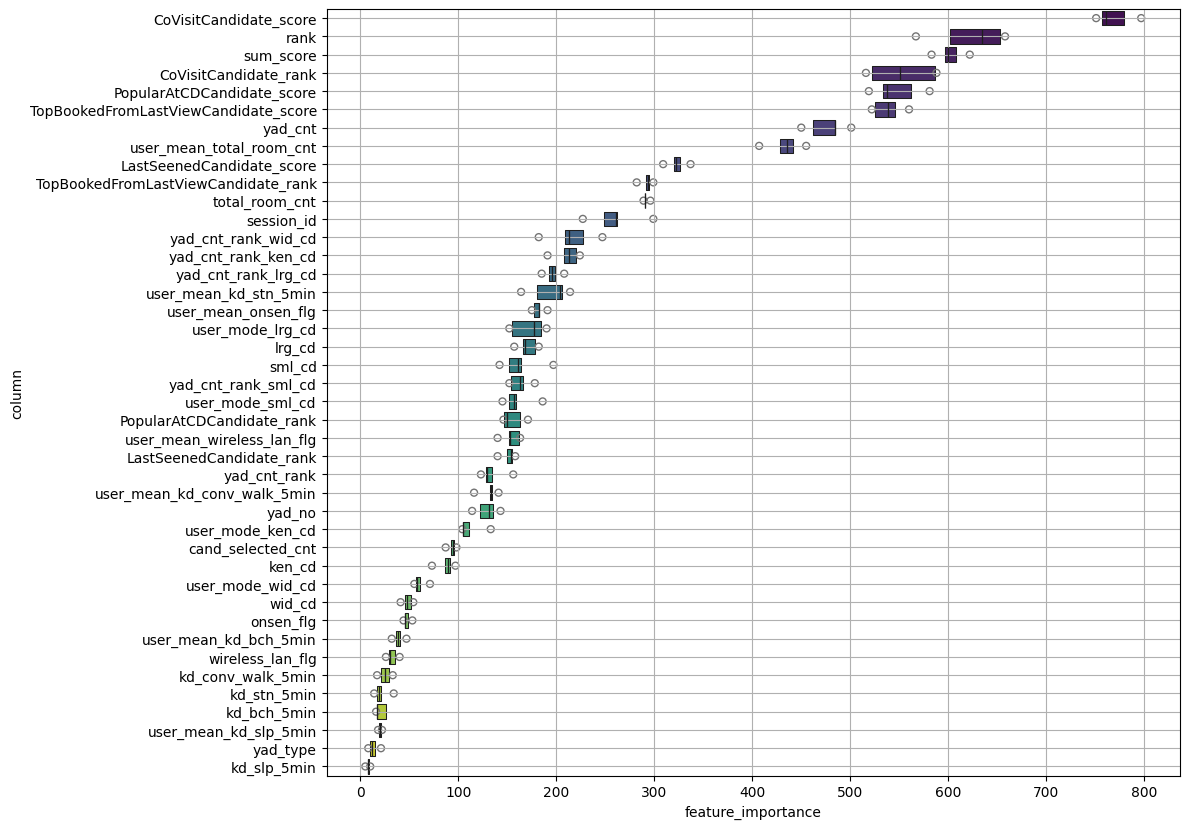

In [14]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(
    pl.DataFrame(cvbooster.feature_importance()), merged_df_dic["train"].drop(["fold", "label"])
)

In [15]:
test_pdf = test_df.to_pandas()

In [130]:
import numpy as np

preds = np.array([gbdt.predict(test_pdf, i) for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

<Axes: ylabel='Count'>

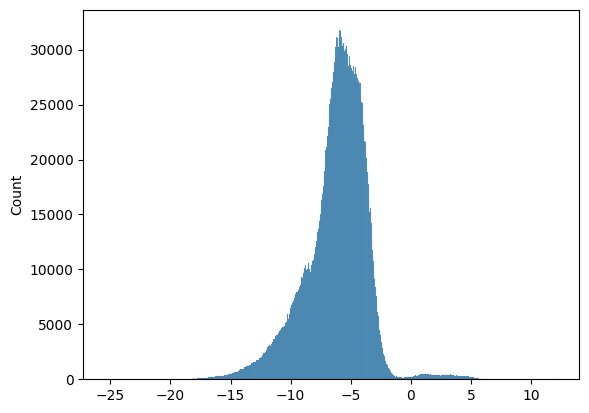

In [131]:
import seaborn as sns

sns.histplot(preds)

<Axes: ylabel='Count'>

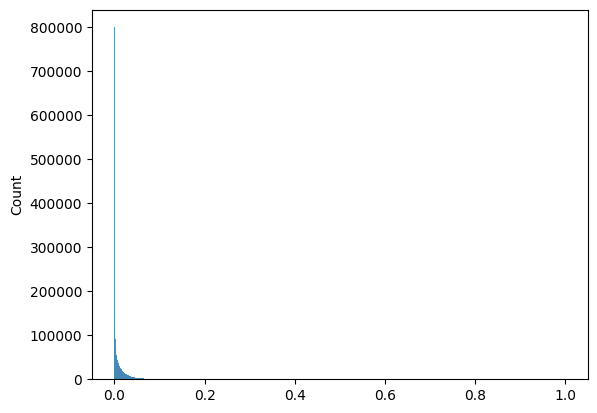

In [132]:
sns.histplot(oof[:, 1])

In [133]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [134]:
# (sub.with_columns(
#     pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
# )
# .sort(["session_id", "rank"])
# .filter(pl.col("rank") <= 9)
# .group_by("session_id", maintain_order=True)
# .agg("yad_no"))

In [135]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [136]:
np.array(fill_sub_lists).shape

(174700, 10)

In [137]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}_add_feat.csv", index=False)